# BDA3 Group Project

### Introduction
Air quality is always critical to citizens and it is obviously serious problem for developing countries. 

This project aims to analyze the PM2.5 in Beijing, make some predictions and give suggestions for dealing with this air pollution problem.

The dataset this problem use is available at UCI Machine Learning Repository. 

Note that this program is implemented on Colab. To run the code, you need to download the [PRSA_data_2010.1.1-2014.12.31.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/00381/), name is as "PRSA_data.csv" and upload it into your own google drive.

## Environment Input

In [123]:
from google.colab import drive
drive.mount('/PRSA_data.csv')

Drive already mounted at /PRSA_data.csv; to attempt to forcibly remount, call drive.mount("/PRSA_data.csv", force_remount=True).


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pystan
import datetime
import seaborn as sns
import warnings

## Dataset Introduction and Preprocessing

The dataset consists of 43824 instances. For each instance, it has 13 columns.

The explanation of each column is:

No: The ID of this instance, i.e. the row number

year / month / day / hour: The year / month / day / hour of this instance

pm2.5: The measured PM2.5 data during this specific hour

DEWP: Dew Point

TEMP: Temperate

PRES: Pressure

cbwd: Combined wind direction

Iws: Cumulated wind speed (m/s)

Is: Cumulated hours of snow

Ir: Cumulated hours of rain



The following presents the first five instances of this dataset to give you a better understanding.

In [125]:
df = pd.read_csv("PRSA_data.csv")

df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [126]:
df.shape

(43824, 13)

As we can read from the instances given above, there are some value missing for our target variable, i.e PM2.5. We checked the dataset and found that there are 2067 instances in total missing this value. Compared to number of instances we have, this is not a big number. Thus, we simply drop these instances to get a valid dataset.

In [127]:
df=df.dropna()

In [128]:
df.shape

(41757, 13)

Visualisation may help us to generate some insights of the dataset. Below is a plot of the pm2.5 distribution. In these five years, the PM2.5 in Beijing is acceptable in most cases, but there are also many terrible situations happened. 

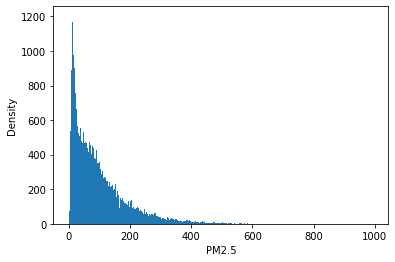

In [129]:
plt.hist(df['pm2.5'],bins=500)
plt.xlabel("PM2.5")
plt.ylabel("Density")
plt.show()

This project would like to examine whether month has an impact on the PM2.5 value. The reason why month is interested other than other variables is month also indicate other information, like the temperature, the snow and rain. Empirically, we thought that the year may also have a relatively great infuence on the PM2.5 because the government might introduce policies to improve the air quality. To figure this out, we also plot the PM2.5 distribution in different years. The diagram below shows that the PM2.5 in different years seems to follow similar distribution.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

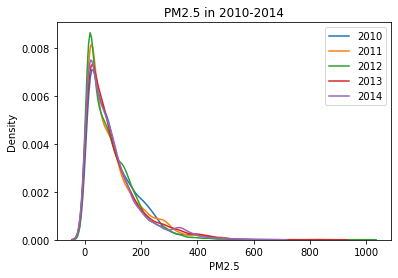

In [130]:
for year in [2010,2011,2012,2013,2014]:
  y=df.loc[df['year']==year,'pm2.5'].tolist()
  sns.distplot(y, label = year, hist=False, kde=True,  bins=int(100))

plt.title("PM2.5 in 2010-2014")
plt.xlabel("PM2.5")
plt.ylabel("Density")
plt.legend()
plt.show()

After examining the year factor, we would like to also check if the hours in one day cause different PM2.5 distribution. We plot the distribution of PM2.5 in one day in the following figure. For a better visualisation, we use step = 4, i.e. only 0, 4, 8, 12, 16, 20 o'clock is ploted. As we can see, the distributions seem to be similar regardless of some value appears more frequenly in some hours. (So our guess that 

We would like to choose 8 o'clock for our project. One reason why we choose 8 o'clock is that people need to go outside and work during that hour. Therefore, PM2.5 data during this hour is more meaningful and important for health than other hours. The other reason is that, 8 o'clock has a wider distribution compared to other day time, such as 12 o'clock and 16 o'clock, which means high PM2.5 data appears more frequently at 8 o'clock.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

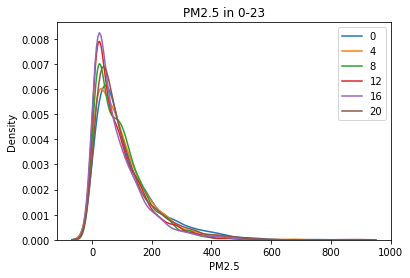

In [131]:
for hour in range(0,24,4):
  pm25_hour=df.loc[df['hour']==hour,'pm2.5'].tolist()
  sns.distplot(pm25_hour, label = hour, hist=False, kde=True,  bins=int(100))
plt.title("PM2.5 in 0-23")
plt.xlabel("PM2.5")
plt.ylabel("Density")
plt.legend()
plt.show()

In [132]:
pm25_at8 = df.loc[df['hour']==8,['month','pm2.5']]

Let us now have some insights of the relationship between month and PM2.5. As we can see from the result given below, in some month starting from March to September, the average PM2.5 is lower than in the winter term.

For generating a suitable input of models, we need to unite the input. We found that because of the missing value that we discarded before and the fact that some months have 30 days but others have 31 days, the total number of instances varies in different months. To simplify our input, we would like to use the first 125 instances at 8 o'clock for each month.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

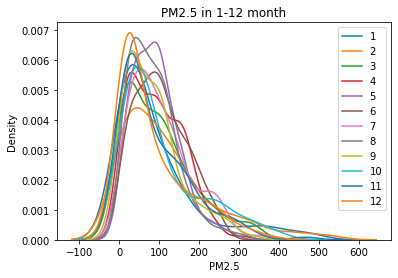

In [133]:
hour8=df.loc[df['hour']==8]
for month in range(1,13):
  newpm25_month=hour8.loc[df['month']==month,'pm2.5'].tolist()
  sns.distplot(newpm25_month, label = month, hist=False, kde=True,  bins=int(100))
plt.title("PM2.5 in 1-12 month")
plt.xlabel("PM2.5")
plt.ylabel("Density")
plt.legend()
plt.show()


In [134]:
avg_month = [];
for month in range(1,13):
  pm25 = df.loc[df['month']==month, 'pm2.5']
  #pm25 = pm25.loc[df['hour']==8, 'pm2.5']
  avg = np.mean(pm25)
  print("Average PM2.5 of month %d is %d" %(month, avg))
  #print("len: %d" %(len(pm25)))
  avg_month.append(avg)


Average PM2.5 of month 1 is 115
Average PM2.5 of month 2 is 125
Average PM2.5 of month 3 is 97
Average PM2.5 of month 4 is 83
Average PM2.5 of month 5 is 80
Average PM2.5 of month 6 is 96
Average PM2.5 of month 7 is 94
Average PM2.5 of month 8 is 79
Average PM2.5 of month 9 is 85
Average PM2.5 of month 10 is 120
Average PM2.5 of month 11 is 105
Average PM2.5 of month 12 is 98


In [136]:
dfs = []
for month in range(1, 13):
  to_add = pm25_at8.loc[df['month']==month,'pm2.5']
  to_add = to_add.head(125)
  to_add = to_add.reset_index(drop=True)
  dfs.append(to_add)
  #input = pd.concat(to_add, axis=0, ignore_index=True)

input = pd.concat(dfs, axis=1, ignore_index=True)
input_transposed = input.transpose()
input_value = input_transposed.values.flatten()
#print(input_value)

## Utility Function

Instead of only interested in the statistical aspect of the PM2.5, we would like to also create a utility function. After searching for the criteria of air quality, the air quality can be categorized into five level according to different PM2.5 value.

Good: 0 ~ 35

Acceptable: 35 ~ 75

Little Air Pollution: 75 ~ 115

Medium Air Pollution: 115 ~ 150

Severe Air Pollution: 150 ~ 250

Terrible Air Pollution: above 250


In [137]:
def utility(data):
  sum = 0
  for row in range(0, len(data)):
    row_content = data.iloc[row]
    if(row_content > 0.0 and row_content<35.0):
      # good air quality!
      sum +=10
    elif (row_content >= 35.0 and row_content<75.0):
      # acceptable air quality
      sum +=1
    elif (row_content >= 75.0 and row_content<115.0):
      # little air pollution
      sum -= 5
    elif (row_content >= 115.0 and row_content<150.0):
      # medium air pollution
      sum -= 10
    elif (row_content >= 150.0 and row_content<250.0):
      # severe air pollution
      sum -= 20
    elif (row_content >= 250.0):
      # terrible air pollution
      sum -= 50
  return sum/len(data)

In [138]:
month_utility = []
for month in range(1,13):
  pm25 = df.loc[df['month']==month, 'pm2.5']
  monthly_utility = utility(pm25)
  month_utility.append(monthly_utility)
  print("Air Quality of month %d is %f" %(month, monthly_utility))


Air Quality of month 1 is -7.269951
Air Quality of month 2 is -9.643048
Air Quality of month 3 is -5.135546
Air Quality of month 4 is -3.047283
Air Quality of month 5 is -2.428096
Air Quality of month 6 is -5.033774
Air Quality of month 7 is -4.816287
Air Quality of month 8 is -2.293078
Air Quality of month 9 is -3.210321
Air Quality of month 10 is -9.588991
Air Quality of month 11 is -6.562125
Air Quality of month 12 is -5.218865


# Model Description

In this project, we would like to use two models: separate model and hierarchical model. The reason why we do not use pooled model is that from our obeservation, assumption and interest we would like to find the relationship between different month and PM2.5. If we use the pooled model, which means all the month share the same parameter, this completely contrast our target.

For both of these models, the weakly informative prior is used.

Similarly, we chose normal distribution and chi-square distribution for hierarchical model.
<br>
The model will calculate two probabilities. First, it is the same as a separate model: how well the parameters represent the data, and secondly, how well a certain hyperparameter reflects all the parameters in different months. Therefore, the results will reflect observations on two levels:
<br>
1.   Level where observations are given the parameters: $p(y_ij|\theta_j)$
2.   Level where parameters are given the hyperparameters: $p(\theta_j|\tau)$

The joint posterior:
$$p(\theta,\tau|y) \propto p(y|\theta,\tau)p(\theta,\tau) \propto p(y|\theta)p(\theta|\tau)p(\tau)$$

## Separate Model


In [139]:
separate = """

data {
  int<lower=0> N; //number of instances for each monoth = 1500
  int<lower=0> J; // = 12 months
  int<lower=1, upper=J> x[N]; // groups indicator
  vector[N] y;
}

parameters {
  vector[J] mu;
  vector<lower=0>[J] sigma;
}

model {
  //priors
  //mu[x] ~ normal (0 , 10000);

  y ~ normal(mu[x],sigma[x]);
}
generated quantities {
  vector[J] ypred;
  vector[N] log_lik;
  for (j in 1:J)
    ypred[j] = normal_rng(mu[j], sigma[j]);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma[x[i]]);
}

"""

In [140]:
separate_test = """

data {
  int<lower=0> N; //number of instances for each monoth = 1500
  int<lower=0> J; // = 12 months
  int<lower=1, upper=J> x[N]; // groups indicator
  vector[N] y;
}

parameters {
  vector<lower=0>[J] mu;
  //vector<lower=0>[J] sigma;
}

model {
  //priors
  mu[x] ~ normal (3 , 1);

  y ~  chi_square(mu[x]);
}
generated quantities {
  vector[J] ypred;
  vector[N] log_lik;
  for (j in 1:J)
    ypred[j] =  chi_square_rng(mu[j]);
  for (i in 1:N)
    log_lik[i] =  chi_square_lpdf(y[i] | mu[x[i]]);
}
"""

In [141]:
separate_skewnorm = """

data {
  int<lower=0> N; //number of instances for each monoth = 1500
  int<lower=0> J; // = 12 months
  int<lower=1, upper=J> x[N]; // groups indicator
  vector[N] y;
  
  int mu_mu;
  int mu_sigma;
  int sigma_mu;
  int sigma_sigma;
  int alpha_mu;
  int alpha_sigma;
}

parameters {
  vector[J] mu;
  vector<lower=0>[J] sigma;
  real alpha;
}

model {
  mu ~ normal(mu_mu, mu_sigma);
  sigma ~ cauchy(sigma_mu, sigma_sigma);
  alpha ~ normal(alpha_mu, alpha_sigma);
  y ~ skew_normal(mu[x], sigma[x], alpha);
}
generated quantities {
  vector[J] ypred;
  vector[N] log_lik;
  for (j in 1:J)
    ypred[j] = skew_normal_rng(mu[j], sigma[j], alpha);
  for (i in 1:N)
    log_lik[i] = skew_normal_lpdf(y[i] | mu[x[i]], sigma[x[i]], alpha);
}

"""

In [142]:
separate_model = pystan.StanModel(model_code=separate)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_31bf22a6a426a4b2c6676e3daac89851 NOW.


In [ ]:
test_model = pystan.StanModel(model_code=separate_test)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_84c7e97e77d76381df74347a4e8446d5 NOW.


In [ ]:
separate_skewnorm_model = pystan.StanModel(model_code=separate_skewnorm)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_abc09039e2ceb07d1503e43ab6d5b9c4 NOW.


In [ ]:
x = [i+1 for i in range(0,12) for j in range(1,126)]
separate_data = dict(
    N = 1500,
    J = 12,
    x = x,
    y = input_value
)

In [ ]:
test_data = dict(
    N = 1500,
    J = 12,
    x = x,
    y = input_value/30
)

In [ ]:
separate_skewnorm_data = dict(
    N = 1500,
    J = 12,
    x = x,
    y = input_value,
    mu_mu = 20,
    mu_sigma = 10000,
    sigma_mu = 90,
    sigma_sigma = 100,
    alpha_mu = 8,
    alpha_sigma = 1
)

In [143]:
x = [i+1 for i in range(0,12) for j in range(1,126)]

#print(x)

In [145]:
fit_separate = separate_model.sampling(data=test_data, n_jobs=-1)
#print(fit_separate)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [144]:
fit_test = test_model.sampling(data=test_data)
#print(fit_test)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [146]:
fit_skewnorm = separate_skewnorm_model.sampling(data=separate_skewnorm_data)
#print(fit_skewnorm)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Hierarchical Model

In [ ]:
hierarchical = '''
data {
  int<lower=0> N; //number of instances for each monoth = 1500
  int<lower=0> J; // = 12 months
  int<lower=1, upper=J> x[N]; // groups indicator
  vector[N] y;
}
parameters {
  real mu0;             // prior mean
  real<lower=0> sigma0;       // prior std
  vector[J] mu;           // means for each month
  real<lower=0> sigma;       // common std
}
model {
    mu ~ normal(mu0, sigma0);
    y ~ normal(mu[x], sigma);
}
generated quantities {
  vector[J] ypred;
  vector[N] log_lik;
  for (j in 1:J)
    ypred[j] = normal_rng(mu[j], sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma);
}
'''

In [ ]:
hierarchical_chi2 = '''
data {
  int<lower=0> N; //number of instances for each monoth = 1500
  int<lower=0> J; // = 12 months
  int<lower=1, upper=J> x[N]; // groups indicator
  vector[N] y;
}
parameters {
  real mu0;             // prior mean
  real<lower=0> sigma0;       // prior std
  vector<lower=0, upper = 10>[J] mu;           // means for each month
}
model {
    mu ~ normal(mu0, sigma0);
    y ~ chi_square(mu[x]);
}
generated quantities {
  vector[J] ypred;
  vector[N] log_lik;
  for (j in 1:J)
    ypred[j] = chi_square_rng(mu[j]);
  for (i in 1:N)
    log_lik[i] = chi_square_lpdf(y[i] | mu[x[i]]);
}
'''

In [ ]:
h_chi2_model = pystan.StanModel(model_code=hierarchical_chi2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e7fd3b266998367552d1ed85ea707ec7 NOW.


In [ ]:
h_model = pystan.StanModel(model_code=hierarchical)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fe1fe178208c650f13907ee9991d44d NOW.


In [ ]:
#the same input for both models
h_data = test_data 

In [147]:
fit_h = h_model.sampling(data=h_data, n_jobs=-1)
#print(fit_h)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [148]:
fit_h_chi2 = h_chi2_model.sampling(data=h_data, n_jobs=-1)
#print(fit_h_chi2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Diagnostics

One important thing before model selection is to examine if the model converge or not. We use the given function [check_hmu_diagnostics](https://mc-stan.org/rstan/reference/check_hmc_diagnostics.html) in Stan to print out a summary of Hamiltonian Monte Carlo Diagnostics.

From the code below, we found that all of our model except hierachical model using normal distribution converge. 

In [ ]:
print("separate model with chi_squared:")
print(pystan.check_hmc_diagnostics(fit_test))

test model:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


In [ ]:
print("separate model with normal:")
print(pystan.check_hmc_diagnostics(fit_separate))

separate model:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


In [ ]:
print("separate model with skew normal:")
print(pystan.check_hmc_diagnostics(fit_skewnorm))

separate model with skew normal:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


In [ ]:
print("hierarchical model with normal:")
print(pystan.check_hmc_diagnostics(fit_h))

hierarchical model:


{'n_eff': True, 'Rhat': True, 'divergence': False, 'treedepth': True, 'energy': True}


In [ ]:
print("hierarchical Chi Squared model:")
print(pystan.check_hmc_diagnostics(fit_h_chi2))

hierarchical Chi Squared model:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


# Model Selection

In the model selection part, we would like to measure the Expected Logarithm Predictive Density (ELPD) Leave One Out (LOO) and use it as a criteria. We will compare the ELPD LOO of different models and select the best one.

### Arviz
We would install Arviz, a package exploratory analysis of Bayesian models and use its function to calculate the ELPD_LOO.

In [ ]:
!pip install arviz

For each model, we would firstly need to check the Pareto K value to see if the LOO result is reliable or not. 

We found that each of separate models has one Pareto K whose value is above 0.5 but 0.7. This is still acceptable. For the hierarchical model, of course we would use the divergent one, so we only check the Pareto key of hierarchical model using Chi Square. And the result shows its PSIS-LOO is reliable.

We need to then compare the EPLD-LOO of these models. We can compare it manually or use the loo_compare function, which would choose the best one (the one with highest ELPD-LOO) and give us a clear result.

For have a better understanding, we print all the result separately below.
The result shows that the Hierarchical model with chi square has best performance. So we would choose it as our model and check if it is sensitive to prior selection.


In [ ]:
import arviz as az
sp_chi2_inference = az.from_pystan(
  posterior=fit_test,
  observed_data=['y'],
  log_likelihood='log_lik'
)

test = az.loo(separate_inference_data, pointwise=True, scale="log")
test

Computed from 4000 by 1500 log-likelihood matrix

         Estimate       SE
elpd_loo -3584.78    35.83
p_loo       29.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1499   99.9%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
sp_normal_inference = az.from_pystan(
  posterior=fit_separate,
  observed_data=['y'],
  log_likelihood='log_lik'
)

s = az.loo(sp_normal_inference, pointwise=True, scale="log")
s

Computed from 4000 by 1500 log-likelihood matrix

         Estimate       SE
elpd_loo -3584.78    35.83
p_loo       29.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1499   99.9%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
sp_skew_normal_inference = az.from_pystan(
  posterior=fit_separate,
  observed_data=['y'],
  log_likelihood='log_lik'
)

sp_skew_normal = az.loo(sp_skew_normal_inference, pointwise=True, scale="log")
sp_skew_normal

Computed from 4000 by 1500 log-likelihood matrix

         Estimate       SE
elpd_loo -3584.78    35.83
p_loo       29.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1499   99.9%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
h_inference_data = az.from_pystan(
  posterior=fit_h,
  observed_data=['y'],
  log_likelihood='log_lik'
)

h = az.loo(h_inference_data, pointwise=True, scale="log")
h

Computed from 4000 by 1500 log-likelihood matrix

         Estimate       SE
elpd_loo -3620.09    41.05
p_loo        6.67        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1500  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [113]:
h_chi2_inference = az.from_pystan(
  posterior=fit_h_chi2,
  observed_data=['y'],
  log_likelihood='log_lik'
)

h_chi2 = az.loo(h_chi2_inference, pointwise=True, scale="log")
h_chi2

Computed from 4000 by 1500 log-likelihood matrix

         Estimate       SE
elpd_loo -3183.67    37.17
p_loo        9.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1500  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Sensitivity analysis with respect to prior choices

In this part, we choose a new prior for our selected model: Hierarchical model using chi squared function. 

In this new prior, we use a very specific piror of the hyper parameter. 
But we will not test a vague prior because we give a bound to the freedom degree of the chi square, i.e. it should be greater than 0 and smaller than 10.

The result shows that, our model is robust to this new prior.

In [105]:
hierarchical_chi2_newprior = """
data {
  int<lower=0> N; //number of instances for each monoth = 1500
  int<lower=0> J; // = 12 months
  int<lower=1, upper=J> x[N]; // groups indicator
  vector[N] y;
}
parameters {
  real mu0;             // prior mean
  real<lower=0> sigma0;       // prior std
  vector<lower=0, upper = 10>[J] mu;           // means for each month
}
model {
    mu0 ~ normal(3.5,0.01);
    sigma0 ~ normal(1,1);
    mu ~ normal(mu0, sigma0);
    y ~ chi_square(mu[x]);
}
generated quantities {
  vector[J] ypred;
  vector[N] log_lik;
  for (j in 1:J)
    ypred[j] = chi_square_rng(mu[j]);
  for (i in 1:N)
    log_lik[i] = chi_square_lpdf(y[i] | mu[x[i]]);
}
"""


In [107]:
h_chi2_newprior_model = pystan.StanModel(model_code=hierarchical_chi2_newprior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1713cb7390dd6fb18df59b1010de5188 NOW.


In [109]:
h_newprior_data = dict(
    N = 1500,
    J = 12,
    x = x,
    y = input_value/30
)

In [149]:
fit_h_newprior_chi2 = h_chi2_newprior_model.sampling(data=h_newprior_data, n_jobs=-1)
#print(fit_h_newprior_chi2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [111]:
print("hierarchical new prior Chi Squared model:")
print(pystan.check_hmc_diagnostics(fit_h_newprior_chi2))

hierarchical new prior Chi Squared model:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


In [115]:
h_newprior_chi2_inference = az.from_pystan(
  posterior=fit_h_newprior_chi2,
  observed_data=['y'],
  log_likelihood='log_lik'
)

h_newprior_chi2 = az.loo(h_chi2_inference, pointwise=True, scale="log")
h_newprior_chi2

Computed from 4000 by 1500 log-likelihood matrix

         Estimate       SE
elpd_loo -3183.67    37.17
p_loo        9.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1500  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

# Conclusion
In conclusion, this project firstly have a look into the dataset with some visualisation method. Then we found that, the PM2.5 in Beijing may have some potential relationship with PM2.5 value, which arouse our intereste. 

We then use two kind of models, the separate model and hierarchical model. For separate model, three distribution is used: normal distribution, chi squared distribution and skew normal distribution. The prior are chosed accordingly. For hierarchical model, we use normal distribution and chi-squared distribution. 

The result shows that the hierachical model with chi-squared distribution has best performance. We also analyze the prior selection for this model and it is robust to new selected prior.

For potential improvement and further research, other distribution should be tested. Moreover, in the model, we also created prediction and provide the utility function. The utility function can also be appled to the prediction from the model on which some practical suggestions can be given. Since our dataset ends at 2014, it is not meaningful anymore to do predictions for 2015. If some latest dataset could be found, the prediction of PM2.5 and suggestions beforehand on also be a great help for our environment.